### Vorticity plot

The notebook can be used to create plot for vorticity computed using zonal and meridional velocities.

In [9]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
import gcm_filters
import xesmf as xe
from xmip.regionmask import merged_mask
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

ModuleNotFoundError: No module named 'ESMF'

In [2]:
def plot_globe(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
               lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap,
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.8)
    cb.ax.tick_params(labelsize=12)
    
    #ax.coastlines()
    
    #ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    #ax.add_feature(cfeature.LAND, facecolor='grey')
    #ax.add_feature(cfeature.COASTLINE)
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
ds_mom = xr.open_dataset("../../Data/OM4p25_JRA55_Momentum_Budget_1958_2017_Mean.nc")

print(ds_mom)

<xarray.Dataset>
Dimensions:             (xq: 1440, yh: 1080, nv: 2, xh: 1440, yq: 1080)
Coordinates:
  * xq                  (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh                  (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * nv                  (nv) float64 1.0 2.0
  * xh                  (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yq                  (yq) float64 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables: (12/67)
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    ubt_dt              (yh, xq) float64 ...
    vbt_dt              (yq, xh) float64 ...
    hf_PFu_2d           (yh, xq) float64 ...
    hf_PFv_2d           (yq, xh) float64 ...
    ...                  ...
    hfgeou              (yh, xh) float32 ...
    sftof               (yh, xh) float32 ...
    wet                 (yh, xh) float32 ...
    wet_c               (yq, xq) float32 ...
    wet_u               (yh, xq

In [4]:
# create grid

grid = Grid(ds_mom, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In [5]:
# get depth-averaged velocities from umo_2d and vmo_2d

rho_0 = 1035.

colh_u = grid.interp(ds_mom['col_height'] * ds_mom['areacello'], 'X',  boundary='fill') / ds_mom['areacello_cu']
colh_v = grid.interp(ds_mom['col_height'] * ds_mom['areacello'], 'Y',  boundary='fill') / ds_mom['areacello_cv']

v_mer = (ds_mom['vmo_2d'] / (rho_0 * ds_mom['dxCv'] * colh_v))
u_mer = (ds_mom['umo_2d'] / (rho_0 * ds_mom['dyCu'] * colh_u))

#print(v_mer, u_mer)

In [6]:
# compute vorticity from depth-avg velocity

vorticity = ( - grid.diff(u_mer * ds_mom['dxCu'], 'Y', boundary='fill')
                   + grid.diff(v_mer  * ds_mom['dyCv'], 'X', boundary='fill') )/ ds_mom.areacello_bu

In [8]:
# Regrid data to equidistant lat-lon for coarse-graining
# We use xesmf bilinear method for regridding

ds_inp = xr.Dataset()

ds_inp['vorticity'] = vorticity

ds_out = xe.util.grid_global(0.25, 0.25) # xesmf inbuit function

grid_model = ds_mom.get(['geolon_c', 'geolat_c'])
grid_model = grid_model.rename({'geolon_c': 'lon','geolat_c': 'lat',})

%time regrid_ds = xe.Regridder(grid_model, ds_out, 'bilinear', periodic=True)

print(regrid_ds)

NameError: name 'xe' is not defined

In [17]:
# use gcm_filters to corsen data to 2-10 deg resolutions

vort_smooth = []

wet_mask = ds_mom['wet_c'].astype(np.float64)
area = ds_mom['areacello_bu'].astype(np.float64)

for i in range(2,11,2):
    
    factor = 4*i # to i deg
    dx_min = 1
    filter_shape = gcm_filters.FilterShape.GAUSSIAN
    
    filter_tripolar_regular_with_land = gcm_filters.Filter(filter_scale=factor, dx_min=1,
                                                           filter_shape=filter_shape, 
                                                           grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
                                                           grid_vars={'area': area, 'wet_mask': wet_mask})
    
    %time ds_smooth = filter_tripolar_regular_with_land.apply(vorticity, dims=['yq', 'xq'])
    
    vort_smooth.append(ds_smooth)

    
vort_smooth = xr.concat(vort_smooth, dim='filter_scale')

CPU times: user 195 ms, sys: 77.5 ms, total: 272 ms
Wall time: 272 ms
CPU times: user 358 ms, sys: 123 ms, total: 481 ms
Wall time: 481 ms
CPU times: user 533 ms, sys: 174 ms, total: 706 ms
Wall time: 706 ms
CPU times: user 706 ms, sys: 224 ms, total: 930 ms
Wall time: 930 ms
CPU times: user 821 ms, sys: 238 ms, total: 1.06 s
Wall time: 1.06 s


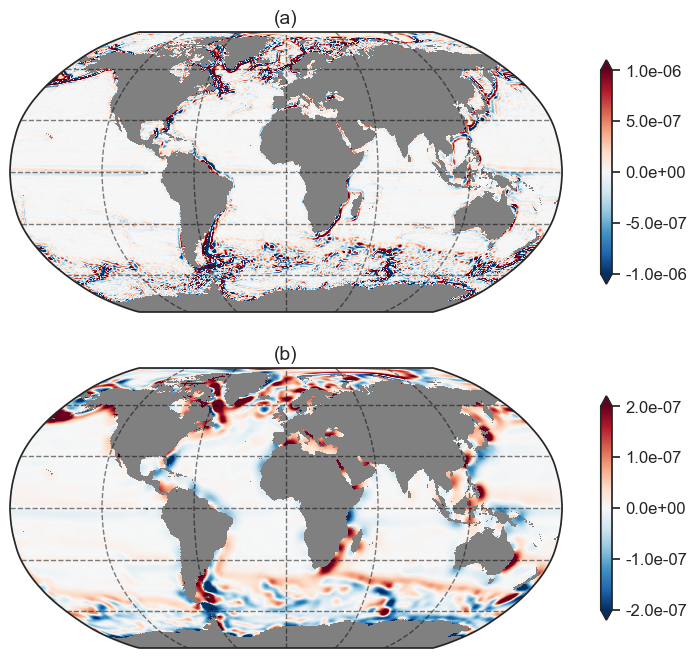

In [46]:
grid1 = plt.GridSpec(2, 1, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[10,8])

tmp = vort_smooth.isel(filter_scale=0).assign_coords({'geolon_c': ds_mom['geolon_c'], 
                                                      'geolat_c': ds_mom['geolat_c']})

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(), facecolor='grey')
_ = plot_globe(ax, tmp, vmin=-1e-6, vmax=1e-6, vstep=2.e-7, lon='geolon_c', 
               lat='geolat_c', cmap='RdBu_r', title='(a)')

tmp = vort_smooth.isel(filter_scale=4).assign_coords({'geolon_c': ds_mom['geolon_c'], 
                                                      'geolat_c': ds_mom['geolat_c']})

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.Robinson(), facecolor='grey')
_ = plot_globe(ax, tmp, vmin=-2e-7, vmax=2e-7, vstep=2.e-7, lon='geolon_c', 
               lat='geolat_c', cmap='RdBu_r', title='(b)')

fig.savefig('../../Plots/Vorticity_depth_avg.png',dpi=300,bbox_inches='tight');

In [44]:
dxw = xr.DataArray(data=ds_mom.dxCu, coords={'yq':ds_mom.yq,'xq':ds_mom.xq}, 
                   dims=('yq','xq'))

dyw = xr.DataArray(data=ds_mom.dyCu, coords={'yq':ds_mom.yq,'xq':ds_mom.xq}, 
                   dims=('yq','xq'))

dxs = xr.DataArray(data=ds_mom.dxCv, coords={'yq':ds_mom.yq,'xq':ds_mom.xq}, 
                   dims=('yq','xq'))

dys = xr.DataArray(data=ds_mom.dyCv, coords={'yq':ds_mom.yq,'xq':ds_mom.xq}, 
                   dims=('yq','xq'))

#dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
#dx_min = dx_min.values
dx_min=10000.

kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

vort_smooth_km = []

wet_mask = ds_mom['wet_c'].astype(np.float64)
area = ds_mom['areacello_bu'].astype(np.float64)

for i in range(2,11,2):
    
    filter_scale = float(100000 * i) # to km
    filter_shape = gcm_filters.FilterShape.GAUSSIAN
    
    filter_irregular_with_land = gcm_filters.Filter(filter_scale=filter_scale,dx_min=dx_min,
                                                    filter_shape=filter_shape, 
                                                    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
                                                    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 
                                                                'dxs': dxs, 'dys': dys, 'area': area, 
                                                                'kappa_w': kappa_w, 'kappa_s': kappa_s})
    
    %time ds_smooth = filter_irregular_with_land.apply(vorticity, dims=['yq', 'xq'])
    
    vort_smooth_km.append(ds_smooth)

    
vort_smooth_km = xr.concat(vort_smooth_km, dim='filter_scale')

CPU times: user 487 ms, sys: 195 ms, total: 682 ms
Wall time: 682 ms
CPU times: user 951 ms, sys: 426 ms, total: 1.38 s
Wall time: 1.38 s
CPU times: user 1.42 s, sys: 645 ms, total: 2.07 s
Wall time: 2.07 s
CPU times: user 1.89 s, sys: 842 ms, total: 2.73 s
Wall time: 2.73 s
CPU times: user 2.39 s, sys: 1.05 s, total: 3.44 s
Wall time: 3.44 s


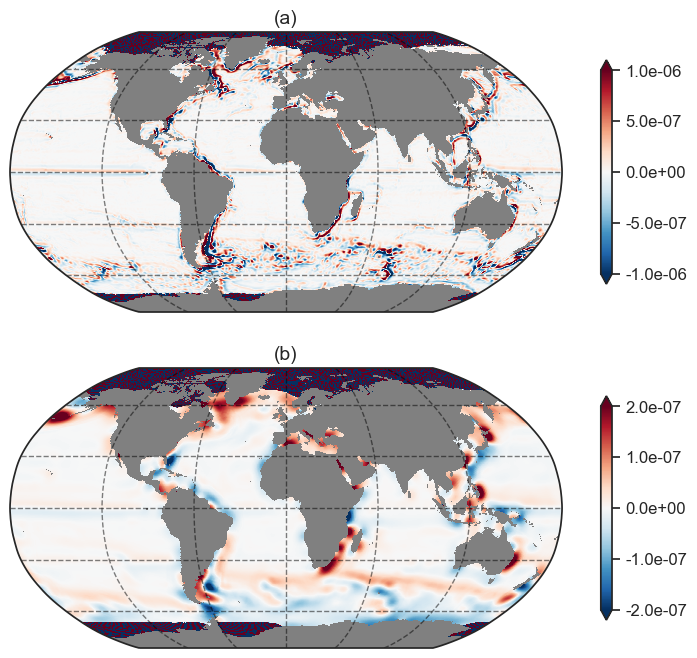

In [45]:
grid1 = plt.GridSpec(2, 1, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[10,8])

tmp = vort_smooth_km.isel(filter_scale=0).assign_coords({'geolon_c': ds_mom['geolon_c'], 
                                                      'geolat_c': ds_mom['geolat_c']})

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(), facecolor='grey')
_ = plot_globe(ax, tmp, vmin=-1e-6, vmax=1e-6, vstep=2.e-7, lon='geolon_c', 
               lat='geolat_c', cmap='RdBu_r', title='(a)')

tmp = vort_smooth_km.isel(filter_scale=4).assign_coords({'geolon_c': ds_mom['geolon_c'], 
                                                      'geolat_c': ds_mom['geolat_c']})

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.Robinson(), facecolor='grey')
_ = plot_globe(ax, tmp, vmin=-2e-7, vmax=2e-7, vstep=2.e-7, lon='geolon_c', 
               lat='geolat_c', cmap='RdBu_r', title='(b)')